## The training setup used

 - Dependancies are listed in `requirements.txt`
 - For inference on custom data see `predict_on_custom_data.ipynb`
 - Pretrained model is available at [model file](https://drive.google.com/file/d/1zQ0WQ8IugTYGKh5rriCxj_FLusXFuZI4/view?usp=sharing)

In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

pd. set_option('display.max_colwidth', None)
tf.get_logger().setLevel('ERROR')

In [3]:
REMOVE_STOP_WORDS = False
APPLY_CUSTOM_CLEANING = False

In [4]:
def remove_stopwords(string):
    word_list = [word.lower() for word in string.split()]
    stopwords_list = list(stopwords.words("english"))
    for word in word_list:
        if word in stopwords_list:
            word_list.remove(word)
    return " ".join(word_list)


def clean_text(text):
    """
    make text lowercase, remove text in square brackets,
    remove punctuation and remove words containing numbers.
    """
    text = str(text).lower()
    text = re.sub("\\n", " ", text)
    text = re.sub(r"https\s+|www.\s+", r"", text)
    text = re.sub(r"http\s+|www.\s+", r"", text)
    text = re.sub(r"\’", "'", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\n", "", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    text = re.sub(r'[?|!|\'|"|#]', r"", text)
    text = re.sub(r"[.|,|)|(|\|/]", r" ", text)
    text = re.sub(r"[0-9]+", "digit", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub("\[.*?\]", "", text)
    text = re.sub(r"\s+", " ", text)
    if REMOVE_STOP_WORDS:
        text = remove_stopwords(text)
    return text

In [5]:
columns = ["tweet", "label"]

train_file = "./data/apple-twitter-sentiment-texts.csv"
data = pd.read_csv(train_file, names=columns, header=0)

class_names = {0: "neutral", 1: "positive", 2:"negative"}
label = {0: 0, 1: 1, -1: 2}
data["label"] = data["label"].map(label)
if APPLY_CUSTOM_CLEANING:
    data["tweet"] = data["tweet"].apply(clean_text)
data.dropna(inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], 
                                                    data["label"], 
                                                    random_state=42, 
                                                    test_size=0.2)

In [7]:
train = pd.DataFrame({'tweet':X_train, 'target':y_train})

test = pd.DataFrame({'tweet':X_test, 'target':y_test})

In [2]:
train.head()

In [ ]:
print("Train data distribution: ")
train.target.value_counts()

In [ ]:
print("Test data distribution: ")
train.target.value_counts()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train['tweet'].values, tf.string), 
                                                   tf.cast(train['target'].values, tf.int32)))

train_ds = raw_train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(test['tweet'].values, tf.string), 
                                                   tf.cast(test['target'].values, tf.int32)))

val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((tf.cast(test['tweet'].values, tf.string), 
                                                   tf.cast(test['target'].values, tf.int32)))

test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

In [9]:

for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(f'Review: {text_batch.numpy()[i]}')

    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"RT @Vito_sfam: Hey @apple, the battery of my iPhone drops down like my cock when I see a gay porn on the xvideos' main page. Fix this shit!"
Label : 2 (negative)
Review: b'Yo @Apple wtf is wrong with you people? Make it easier to delete contacts already, gosh damn it!!!'
Label : 2 (negative)
Review: b'RT @JPDesloges: APPLE - Fibonacci Technicals Levels - Intraday  Update - $AAPL #aapl \r\nhttp://t.co/t2uV8nZ46v'
Label : 0 (neutral)
Review: b'MacBook Pro 13in Unboxing: http://t.co/F3IM9YbpxF via @youtube @apple #macbook #macbookpro #startup #hipster #unboxing'
Label : 0 (neutral)
Review: b"If you have an iPad 2, DON'T update it to iOS8, it's buggy and slow! #apple @apple"
Label : 2 (negative)
Review: b'Here are the top apps for the iPhone according to @apple http://t.co/6gzv72TrNY #technologya'
Label : 0 (neutral)
Review: b'Do i have to go to @Apple if idr the code? -_-'
Label : 0 (neutral)
Review: b'@5SOS OMG THIS WOULD ACTUALLY BE A RLLY CUTE EMOJI @apple'
Label : 0 (neutral

In [10]:
#Choose a BERT model to fine-tune
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

# wanto try a larger model?
# bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [12]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262933  0.99280983 -0.18611841  0.36673838  0.1523371   0.65504414
  0.9681154  -0.94862705  0.00216196 -0.9877732   0.06842704 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946352  0.3432127   0.33231536 ...  0.2130082   0.71020764
  -0.05771179]
 [-0.28742087  0.31981015 -0.2301858  ...  0.5845512  -0.2132979
   0.72692066]
 [-0.66156995  0.688768   -0.8743304  ...  0.10877246 -0.2617323
   0.47855377]
 ...
 [-0.22561169 -0.2892561  -0.07064427 ...  0.47566015  0.8327705
   0.4002538 ]
 [-0.29824227 -0.2747312  -0.05450515 ...  0.48849764  1.0955355
   0.18163416]
 [-0.44378257  0.00930772  0.07223713 ...  0.17290124  1.1833248
   0.07897964]]


In [15]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(512, activation='relu', name='dense1')(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    out = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, out)

In [16]:
classifier_model = build_classifier_model()

In [17]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [19]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [20]:
class_weight = {0:1, 1:2, 2:1}

In [21]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [22]:

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs, 
                               class_weight=class_weight)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
41/41 [==============================] - 104s 2s/step - loss: 1.4113 - categorical_accuracy: 0.3923 - val_loss: 0.6506 - val_categorical_accuracy: 0.5276
Epoch 2/10
41/41 [==============================] - 95s 2s/step - loss: 0.9619 - categorical_accuracy: 0.5250 - val_loss: 0.5839 - val_categorical_accuracy: 0.5982
Epoch 3/10
41/41 [==============================] - 95s 2s/step - loss: 0.7931 - categorical_accuracy: 0.5335 - val_loss: 0.5033 - val_categorical_accuracy: 0.5337
Epoch 4/10
41/41 [==============================] - 96s 2s/step - loss: 0.6419 - categorical_accuracy: 0.5201 - val_loss: 0.4608 - val_categorical_accuracy: 0.5276
Epoch 5/10
41/41 [==============================] - 95s 2s/step - loss: 0.5080 - categorical_accuracy: 0.5086 - val_loss: 0.4266 - val_categorical_accuracy: 0.5675
Epoch 6/10
41/41 [==============================] - 97s 2s/step - loss: 0.4028 - catego

In [23]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

11/11 [==============================] - 6s 563ms/step - loss: 0.4179 - categorical_accuracy: 0.5276
Loss: 0.417915940284729
Accuracy: 0.5276073813438416


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


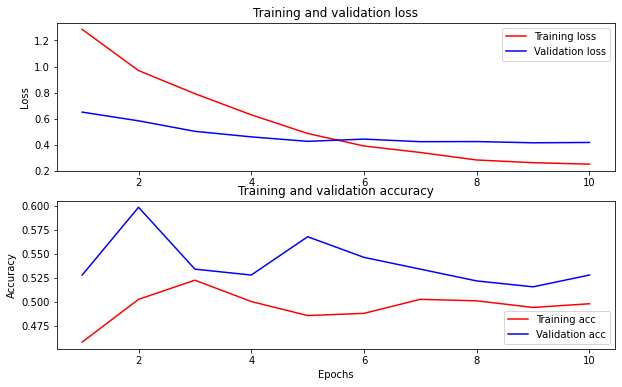

In [33]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
y_pred = np.argmax(classifier_model.predict(test_ds), axis=1)

In [26]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 13)
    plt.yticks(tick_marks, classes, fontsize = 13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 17)
    plt.xlabel('Predicted label', fontsize = 17)

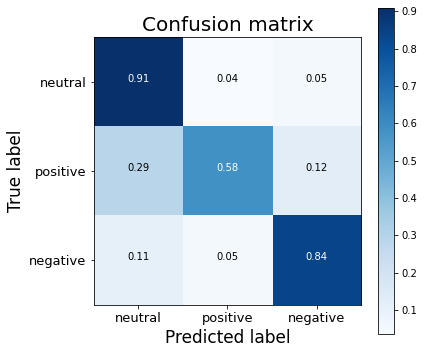

In [27]:
cnf_matrix = confusion_matrix(y_test.to_list(), y_pred)
plt.figure(figsize = (6,6))
plot_confusion_matrix(cnf_matrix, classes = class_names.values(), title = "Confusion matrix")
plt.show()

In [28]:
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       165
           1       0.52      0.58      0.55        24
           2       0.91      0.84      0.87       137

    accuracy                           0.86       326
   macro avg       0.77      0.78      0.77       326
weighted avg       0.86      0.86      0.86       326



In [29]:
dataset_name = 'apple'
saved_model_path = './{}_model'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [34]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i]}  : class: {class_names[np.argmax(results[i])]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'how can I login to app store?'
]
if APPLY_CUSTOM_CLEANING:
    examples = [clean_text(text) for text in examples]
original_results = classifier_model(tf.constant(examples))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: [0.00374166 0.99136215 0.00489621]  : class: positive
input: The movie was great!           : score: [0.00444103 0.9867165  0.00884237]  : class: positive
input: The movie was meh.             : score: [0.22289412 0.6971022  0.08000365]  : class: positive
input: The movie was okish.           : score: [0.07919228 0.8682619  0.0525458 ]  : class: positive
input: The movie was terrible...      : score: [0.00729853 0.01884586 0.9738556 ]  : class: negative
input: how can I login to app store?  : score: [0.89651954 0.02201089 0.08146952]  : class: neutral

